In [1]:
from pathlib import Path

MODEL = "latte(B, stride=1, patch_size=1, latte_vae, 205)"
EPOCH = 1000
cfg_path = "configs/training/libero/tra-moe/latent/base.yaml"
ckpt_path = f"/work/gabrijel/what-happnes-next-checkpoints/track-generator/libero/tra-moe/latent/ckpt_epoch={EPOCH}.pth"

In [2]:
ckpt_path

'/work/gabrijel/what-happnes-next-checkpoints/track-generator/libero/tra-moe/latent/ckpt_epoch=1000.pth'

In [3]:
from omegaconf import OmegaConf

cfg = OmegaConf.load(cfg_path)
cfg

{'model': {'name': 'latte(B, stride=${model.nn.trajectory_stride}, patch_size=${model.nn.patch_size}, latte_vae, 205, optimized)', 'nn': {'image_size': 128, 'input_size': 16, 'in_channels': 8, 'trajectory_length': 16, 'patch_size': 1, 'trajectory_stride': 1, 'frame_features_dim': 1024, 'text_embed_dim': 768, 'num_frame_tokens': 81, 'latent': True}, 'flow_matcher': 'target_conditional_flow_matcher', 'vae': {'type': 'latte', 'ckpt': '/work/gabrijel/what-happnes-next-checkpoints/track-vae/atm_libero_grid_tramoe/205.pth', 'scale': [1.2902071, 1.9394214, 1.9453552, 1.562121, 2.2335691, 1.0033306, 0.8569633, 0.73737895]}}, 'training': {'batch_size': 32, 'num_workers': 4, 'lr': 6e-05, 'seed': 42, 'use_amp': True, 'use_wandb': True, 'epochs': 2048, 'num_steps_per_epoch': 896, 'log_every_steps': 64, 'checkpoint_every_epochs': 10, 'sample_every_steps': 8960, 'num_trajectories_per_reference_frame': 4096, 'samples_path': '/scratch/shared/beegfs/gabrijel/experiments/track-generator/${dataset.name}/

In [4]:
import torch

device = torch.device("cuda:2")

In [5]:
def get_sampling_seed(rollout_index: int) -> int:
    import numpy as np
    np.random.seed(42)
    seeds = np.random.randint(0, 2**32, size=64 + 1, dtype=np.uint32)
    return seeds[rollout_index].item()

### Load VAE

In [6]:
from nn_latte_vae import LatteVAE

vae = LatteVAE(
    encoder_depth=12,
    decoder_depth=12,
    hidden_size=384,
    patch_size=4,
    num_heads=6,
    in_channels=2,
    latent_channels=8,
    input_size=64,
    num_frames=16,
    num_frame_tokens=81,
    frame_features_dim=1024,
    learn_sigma=False
)
ckpt = torch.load(
    cfg.model.vae.ckpt,
    map_location=device,
    weights_only=True
)
vae.load_state_dict(
    state_dict={
        k.replace("module.", ""): v
        for (k, v) in ckpt[f"model_state_dict"].items()
    }
)
vae = vae.to(device)
vae.eval()
vae_scale = 1.0 / torch.tensor(
    cfg.model.vae.scale,
    device=device
)

/users/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/athenahomes/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load Denoiser

In [7]:
from seed import seed_everything
from core import get_model

rollout_idx = 0
seed = get_sampling_seed(rollout_idx)
seed_everything(seed)
weights = "model"
# Load model
model = get_model(cfg).to(device)
ckpt = torch.load(
    ckpt_path,
    map_location="cpu"
)
state_dict = {
    key.replace("module.", ""): value
    for (key, value) in ckpt[f"{weights}_state_dict"].items()
}
state_dict = {
    key.replace("_orig_mod.", ""): value
    for (key, value) in state_dict.items()
}
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

/tmp/ipykernel_1875982/1168319642.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(


Latte(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(8, 384, kernel_size=(1, 1), stride=(1, 1))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (frame_proj): Linear(in_features=1024, out_features=384, bias=True)
  (text_embeds_proj): Mlp(
    (fc1): Linear(in_features=768, out_features=1536, bias=True)
    (act): GELU(approximate='tanh')
    (drop1): Dropout(p=0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=1536, out_features=384, bias=True)
    (drop2): Dropout(p=0, inplace=False)
  )
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (norm1): RMSNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): SelfAttention(
        (q): Linear(in_features=384, out_features=384, bias=True)
        (kv): Linear(in_features=384, out_features=768, bias=True)
  

In [8]:
from core import get_dataloaders
from dataset_split import DatasetSplit
from seed import seed_everything
import webdataset as wds
from sample_libero_benchmark import map_to_tuple

seed_worker_fn = seed_everything(cfg.training.seed)
tar_idx = 0
suite = "libero_10"
batch_size = 8

val_urls = list(
    Path(
        f"./datasets/libero/tra-moe/{suite}/validation").iterdir()
)
valset = wds.DataPipeline(
    wds.SimpleShardList(
        urls=[str(x) for x in val_urls][tar_idx]
    ),
    wds.split_by_worker,
    wds.tarfile_to_samples(),
    wds.decode(),
    wds.map(map_to_tuple),
    wds.batched(batch_size),
)

In [9]:
val_iterator = iter(valset)
val_batch = next(val_iterator)

In [10]:
(
    agent_frames,
    agent_frames_features,
    agent_tracks,
    gripper_frames,
    gripper_frames_features,
    gripper_tracks,
    instructions,
    instruction_features,
    instruction_pooled,
    key
) = val_batch

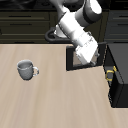

In [11]:
from PIL import Image

Image.fromarray(agent_frames[0, 0].numpy())

In [12]:
from sample_libero_benchmark import sample_rollout_tracks_latent

sampled_agent_tracks = sample_rollout_tracks_latent(
    model,
    vae,
    vae_scale,
    agent_frames_features,
    instruction_features,
    instruction_pooled,
    rollout_idx,
    1,
    device,
)

sampling rollout ...
sampling method=euler, steps=10, atol=1e-07, rtol=1e-07 ...


In [13]:
from sample_libero_benchmark import sample_rollout_tracks_latent

sampled_gripper_tracks = sample_rollout_tracks_latent(
    model,
    vae,
    vae_scale,
    gripper_frames_features,
    instruction_features,
    instruction_pooled,
    rollout_idx,
    1,
    device,
)

sampling rollout ...
sampling method=euler, steps=10, atol=1e-07, rtol=1e-07 ...


In [14]:
sampled_gripper_tracks.min(), sampled_gripper_tracks.max()

(tensor(-28.8877), tensor(153.5908))

In [15]:
sampled_gripper_tracks.shape

torch.Size([8, 16, 64, 64, 2])

In [16]:
from einops import rearrange
from PIL import Image

from cotracker_utils import Visualizer


visualizer = Visualizer(
    "./demos/libero/tra-moe/agent",
    linewidth=1,
    fps=10,
)

for batch_idx in range(agent_frames.shape[0]):
    Image.fromarray(agent_frames[batch_idx, 0].numpy()).save(
        f"./demos/libero/tra-moe/agent/init_cond_{batch_idx}.jpg"
    )
    visualizer.visualize(
        video=rearrange(
            torch.zeros_like(agent_frames[[batch_idx], ...]),
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            sampled_agent_tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"pred_{batch_idx}"
    )
    visualizer.visualize(
        video=rearrange(
            agent_frames[[batch_idx], ...],
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            agent_tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"gt_{batch_idx}"
    )

In [17]:
from einops import rearrange
from PIL import Image

from cotracker_utils import Visualizer


visualizer = Visualizer(
    "./demos/libero/tra-moe/gripper",
    linewidth=1,
    fps=10,
)

for batch_idx in range(gripper_frames.shape[0]):
    Image.fromarray(gripper_frames[batch_idx, 0].numpy()).save(
        f"./demos/libero/tra-moe/gripper/init_cond_{batch_idx}.jpg"
    )
    visualizer.visualize(
        video=rearrange(
            torch.zeros_like(gripper_frames[[batch_idx], ...]),
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            sampled_gripper_tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"pred_{batch_idx}"
    )
    visualizer.visualize(
        video=rearrange(
            gripper_frames[[batch_idx], ...],
            "b t h w c -> b t c h w"
        ),
        tracks=rearrange(
            gripper_tracks[[batch_idx], ...],
            "b t h w c -> b t (h w) c"
        ),
        filename=f"gt_{batch_idx}"
    )